In [104]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [105]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)
productivity.index = productivity.samples

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [106]:
samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
index = target.index.drop(samples_to_drop)

In [107]:
'''Set sample names as index and shuffle data'''
productivity = productivity.loc[target.samples.values,:]
productivity.index= target.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=hna.index)
lna_rel = pd.Series(lna_rel, index=hna.index)

**-- PREPROCESSING OF DATA --**

**1)**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter $abun$. 

In [108]:
'''Filtering based on productivity samples, not needed for first part of analysis'''
#retain only productivity samples 
#productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
#productivity = productivity[productivity.tot_bacprod < 90]

#idx_prod = productivity.samples.values
#display(idx_prod)
#prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
#prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
#prod_rel_error = prod_error/prod

'Filtering based on productivity samples, not needed for first part of analysis'

In [109]:
'''Parameter abun for initial filtering of OTUs'''
abun = 0.001

In [110]:
from analysis_functions import preprocess_df
data_abs = preprocess_df(data_abs,abun,True)
otus = list(data_abs.columns)

print('Number of OTUs: ' + str(len(otus)))

Number of OTUs: 1245


(Note that this number is the same whether we use absolute or relative abundances, as the filtering is based on a minimal _relative_ abundance.)

In [111]:
#Some variables to store information and to create inner and outer CV-folds

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

thresholds = np.arange(0,1,0.01)
t = 0

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

In [112]:
lassoCV = get_lassoCV(cv)
scaler = StandardScaler()
scaler.fit(data_abs.loc[:,otus])
data_stand = pd.DataFrame(scaler.transform(data_abs[otus]),index=data_abs.index,columns=otus)    
lassoCV.fit(data_stand.loc[:,otus], hna)
mse = np.sum(lassoCV.mse_path_, axis=1)
mse_min = np.min(mse)
alpha = lassoCV.alpha_
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')
        
mse_scores = np.zeros(len(thresholds))
dummy=0
scores = otu_scores
    
for thr in thresholds: 
    scores = otu_scores[otu_scores.values > thr]
    features_new = scores.index
    if(len(features_new) > 0): 
        lassoCV = get_lassoCV(cv)
        lassoCV.fit(data_stand.loc[:,features_new],hna)
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna) #We could use this if we want a different evaluation model
        mse = np.sum(lassoCV.mse_path_, axis=1)
        mse_scores[dummy] = np.min(mse)
    dummy+=1
        
mse_scores = mse_scores[np.nonzero(mse_scores)]
mse_min_idx = mse_scores.argmin()
thresh_max = thresholds[mse_min_idx]
optimal_scores = otu_scores[otu_scores.values>thresh_max]
selected_otus = optimal_scores.index
    
lassoCV = get_lassoCV(cv)
lassoCV.fit(data_stand.loc[:, selected_otus], hna)
alpha = lassoCV.alpha_
lasso = Lasso(alpha,max_iter=20000,normalize=False)
pred = cross_val_predict(lasso, data_stand.loc[:, selected_otus], hna, cv=cv)

In [113]:
r2_final = get_r2(pred,hna)   
print('R²_cv: ' + str(r2_final) )

R²_cv: 0.969336662488


In [114]:
hna_scores = optimal_scores
hna_scores = hna_scores.assign(abun_abs_mean = data_abs.loc[:,selected_otus].mean())
hna_scores = hna_scores.assign(abun_abs_CV = data_abs.loc[:,selected_otus].std()/data_abs.loc[:,selected_otus].mean())
hna_scores = hna_scores.assign(abun_rel_mean = data_rel.loc[:,selected_otus].mean())
hna_scores = hna_scores.assign(abun_rel_CV = data_rel.loc[:,selected_otus].std()/data_rel.loc[:,selected_otus].mean())
hna_scores.to_csv('hna_scores_abun0.001.csv')
display(hna_scores.head(10))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000009,0.693333,150958.577254,0.788330,0.031635,0.507992
Otu000382,0.580000,102.601406,5.578846,0.000135,6.026530
Otu000344,0.576667,5017.330882,1.439002,0.000888,1.275341
Otu000123,0.570000,14449.881929,1.521067,0.002315,1.307041
Otu000176,0.560000,7582.179430,1.454066,0.001477,1.095974
Otu000227,0.550000,2468.550148,1.373379,0.000494,1.177623
Otu000067,0.546667,14365.114339,1.395872,0.004392,1.384364
Otu007625,0.543333,73.509481,9.868519,0.000020,8.768991
Otu000011,0.533333,168900.635115,1.016108,0.034066,0.641350
Otu000025,0.530000,77605.710439,1.012949,0.014966,0.755597


Is there a relationship between mean abundance and standardeviation? 

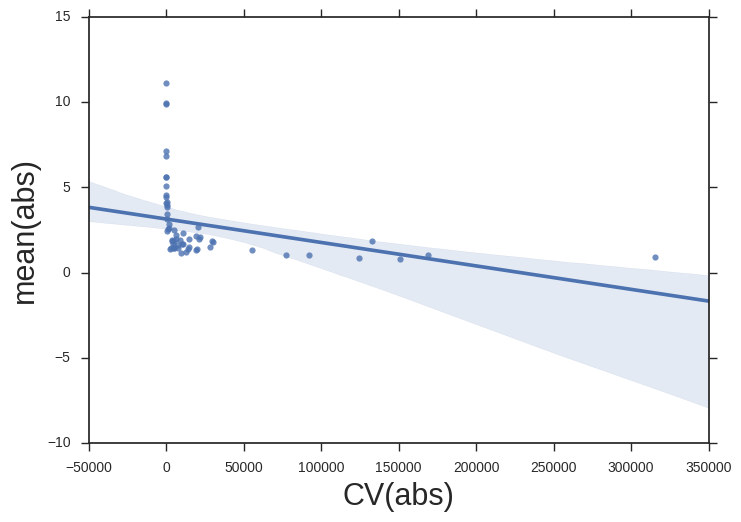

In [115]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=hna_scores)
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

In [116]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [117]:
lassoCV = get_lassoCV(cv)

lassoCV.fit(data_stand.loc[:,otus], lna)
mse = np.sum(lassoCV.mse_path_, axis=1)
mse_min = np.min(mse)
alpha = lassoCV.alpha_
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True,by='score')
        
mse_scores = np.zeros(len(thresholds))
dummy=0
scores = otu_scores
    
for thr in thresholds: 
    scores = otu_scores[otu_scores.values > thr]
    features_new = scores.index
    if(len(features_new) > 0): 
        lassoCV = get_lassoCV(cv)
        lassoCV.fit(data_stand.loc[:,features_new],lna)
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],lna) #We could use this if we want a different evaluation model
        mse = np.sum(lassoCV.mse_path_, axis=1)
        mse_scores[dummy] = np.min(mse)
    dummy+=1
        
mse_scores = mse_scores[np.nonzero(mse_scores)]
mse_min_idx = mse_scores.argmin()
thresh_max = thresholds[mse_min_idx]
optimal_scores = otu_scores[otu_scores.values>thresh_max]
selected_otus = optimal_scores.index
    
lassoCV = get_lassoCV(cv)
lassoCV.fit(data_stand.loc[:, selected_otus], lna)
alpha = lassoCV.alpha_
lasso = Lasso(alpha,max_iter=20000,normalize=False)
pred = cross_val_predict(lasso, data_abs.loc[:, selected_otus], lna, cv=cv)

In [118]:
r2_final_lna = get_r2(pred,lna)   
print('R²_cv: ' + str(r2_final_lna) )

R²_cv: 0.771303714773


This means that the LNA-dynamics can be predicted up to roughly the same precision. 

In [122]:
lna_scores = optimal_scores
lna_scores.to_csv('lna_scores_abun0.001.csv')
lna_scores = lna_scores.assign(abun_abs_mean = data_abs.loc[:,selected_otus].mean())
lna_scores = lna_scores.assign(abun_abs_CV = data_abs.loc[:,selected_otus].std()/ data_abs.loc[:,selected_otus].mean())
lna_scores = lna_scores.assign(abun_rel_mean = data_rel.loc[:,selected_otus].mean())
lna_scores = lna_scores.assign(abun_rel_CV = data_rel.loc[:,selected_otus].std()/data_rel.loc[:,selected_otus].mean())
lna_scores.to_csv('lna_scores_abun0.001.csv')
display(hna_scores.head(10))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000009,0.693333,150958.577254,0.788330,0.031635,0.507992
Otu000382,0.580000,102.601406,5.578846,0.000135,6.026530
Otu000344,0.576667,5017.330882,1.439002,0.000888,1.275341
Otu000123,0.570000,14449.881929,1.521067,0.002315,1.307041
Otu000176,0.560000,7582.179430,1.454066,0.001477,1.095974
Otu000227,0.550000,2468.550148,1.373379,0.000494,1.177623
Otu000067,0.546667,14365.114339,1.395872,0.004392,1.384364
Otu007625,0.543333,73.509481,9.868519,0.000020,8.768991
Otu000011,0.533333,168900.635115,1.016108,0.034066,0.641350
Otu000025,0.530000,77605.710439,1.012949,0.014966,0.755597


Do we see the 'low'-abundance effect as in the HNA-counts also here? 

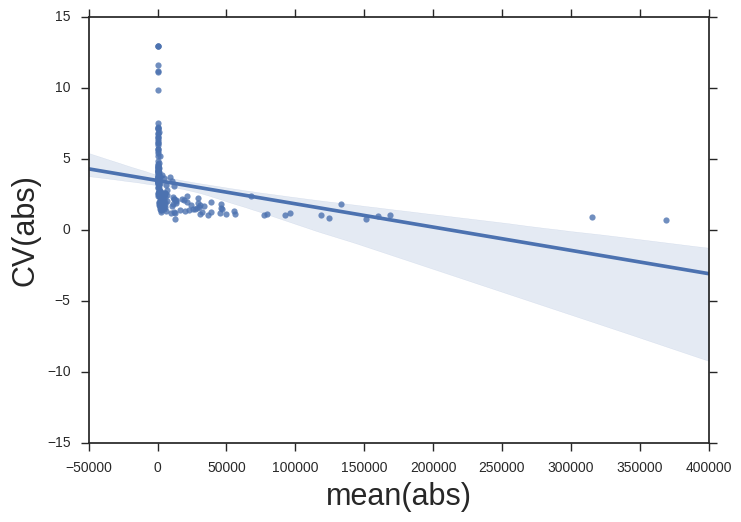

In [123]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=lna_scores)
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [135]:
idx_hna = hna_scores.index.difference(lna_scores.index)
idx_lna = lna_scores.index.difference(hna_scores.index)
idx_common = hna_scores.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_abun.001.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(hna_scores)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(lna_scores)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(lna_scores.loc[idx_common,:])
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 33; opposed to total size: 60
Size subset OTUs only related to LNA: 166; opposed to total size: 193
Size subset OTUs related to both: 27


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000009,0.583333,150958.577254,0.788330,0.031635,0.507992
Otu000382,0.580000,102.601406,5.578846,0.000135,6.026530
Otu000227,0.200000,2468.550148,1.373379,0.000494,1.177623
Otu007625,0.540000,73.509481,9.868519,0.000020,8.768991
Otu000011,0.330000,168900.635115,1.016108,0.034066,0.641350
Otu000025,0.376667,77605.710439,1.012949,0.014966,0.755597
Otu000047,0.210000,19404.490287,2.128604,0.003984,1.963976
Otu000487,0.370000,3320.641086,1.464180,0.000575,1.318470
Otu000004,0.513333,315529.656001,0.929570,0.066357,0.586675
Otu000765,0.296667,119.842712,6.826912,0.000054,6.312812


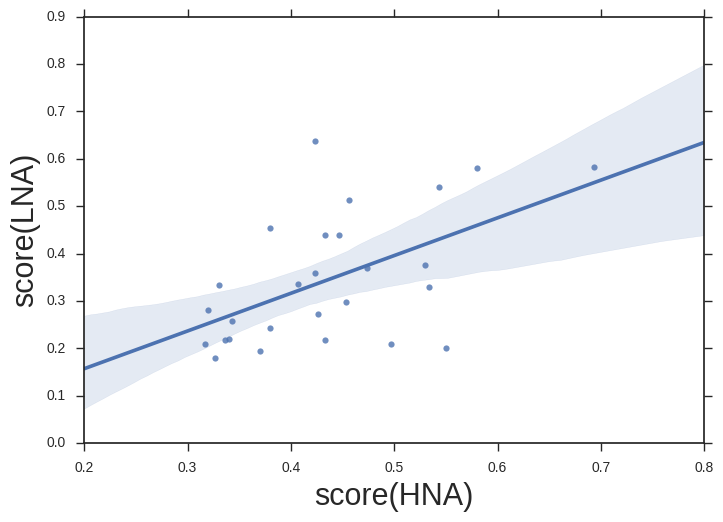

In [133]:
plt.figure()
sns.regplot(x=hna_scores.loc[idx_common,'score'],y=lna_scores.loc[idx_common,'score'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 